In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import lightgbm
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-fare-prediction-mh/Data_Train.xlsx
/kaggle/input/flight-fare-prediction-mh/Sample_submission.xlsx
/kaggle/input/flight-fare-prediction-mh/Test_set.xlsx


Load the train data and drop the null rows
There are no missing values afterwards

In [2]:
df = pd.read_excel('../input/flight-fare-prediction-mh/Data_Train.xlsx', engine='openpyxl')
df = df.dropna()
print(df.isnull().sum())

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64


Let's check the dataframe's head!

In [3]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


We should preprocess the data first
As you can see the columns cannot be fed into models because they are not in the right format.
They are all objects
We should turn them somehow into numerical features

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


Let's check some columns to see if they provide useful information

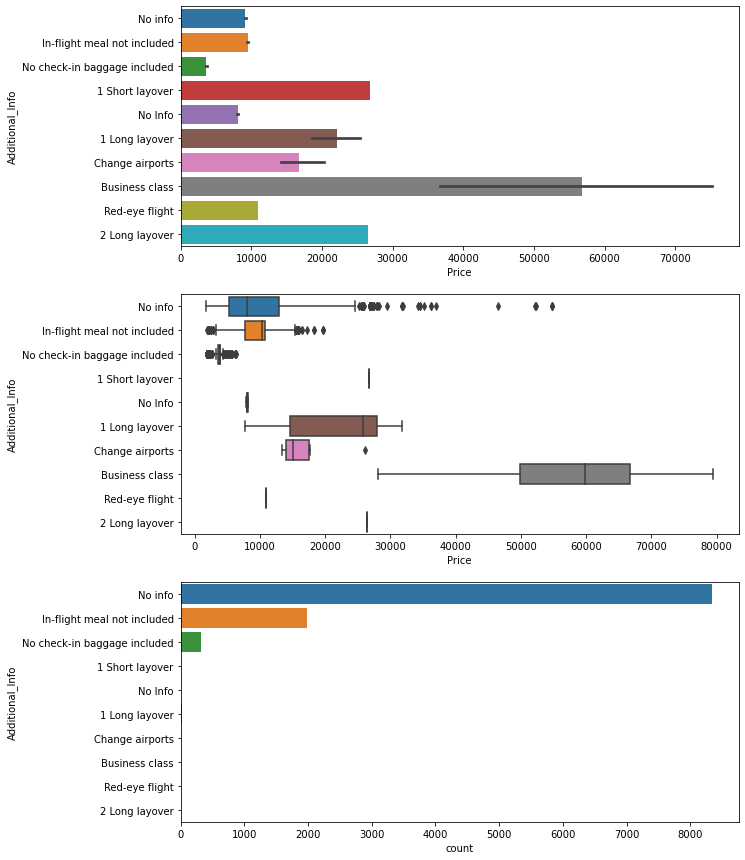

In [5]:
fig, ax = plt.subplots(3,1, figsize=(10,15))
sns.barplot(y='Additional_Info', x='Price', data=df, ax=ax[0])
sns.boxplot(y='Additional_Info', x='Price', data=df, ax=ax[1])
sns.countplot(y='Additional_Info', data=df, ax=ax[2])
plt.show()

It shows that the business class have higher prices than other classes
But most of this column consists of No info
so we drop this coulmn for simplicity's sake

In [6]:
df['Route'].value_counts()

DEL → BOM → COK                2376
BLR → DEL                      1552
CCU → BOM → BLR                 979
CCU → BLR                       724
BOM → HYD                       621
                               ... 
BOM → UDR → DEL → HYD             1
BOM → DED → DEL → HYD             1
CCU → RPR → HYD → BLR             1
BLR → HBX → BOM → AMD → DEL       1
BOM → RPR → VTZ → HYD             1
Name: Route, Length: 128, dtype: int64

There are 128 types of this column and they don't provide general information we can use.
So let's drop the Additional info and Route columns

In [7]:
df = df.drop(columns=['Additional_Info', 'Route'], axis=1)

Let's explore some other columns as well

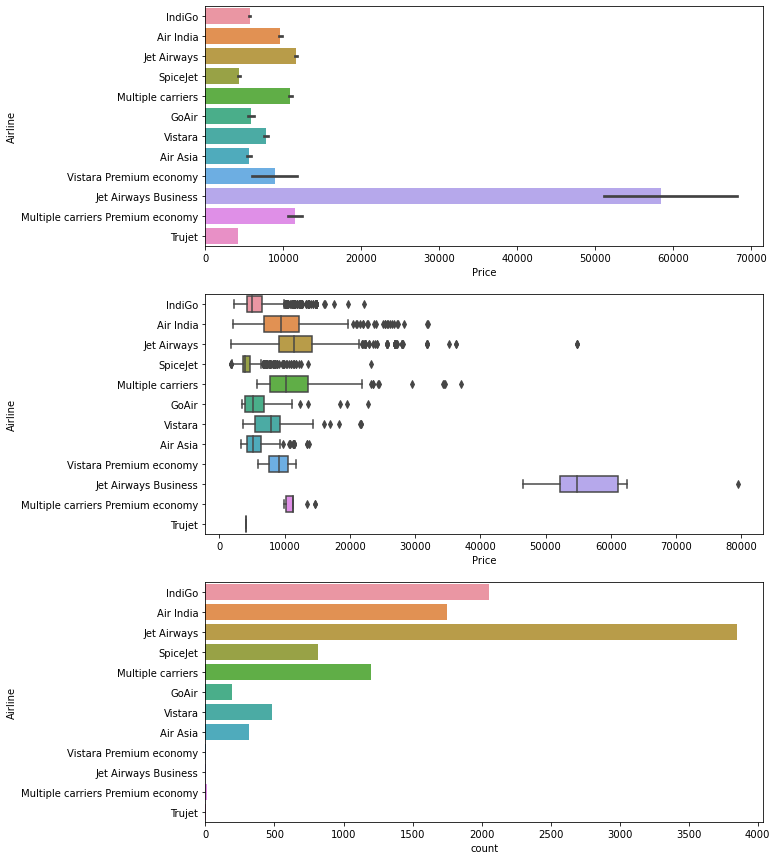

In [8]:
fig, ax = plt.subplots(3,1, figsize=(10,15))
sns.barplot(y='Airline', x='Price', data=df, ax=ax[0])
sns.boxplot(y='Airline', x='Price', data=df, ax=ax[1])
sns.countplot(y='Airline', data=df, ax=ax[2])
plt.show()

In [9]:
df['Airline'].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

We can see that the jet Airways Business have the highest price although there are not many 
In fact we cannot be sure if our model predicts well for the last 4 airlines which have less than 20 counts each
But we also need this information to provide predictions based on airlines
We also will have more uncertainty if our test set contains other distribution of airlines
So we replace the last 4 airplanes with 'Other'

In [10]:
df = df.replace(['Trujet', 'Vistara Premium economy', 'Jet Airways Business', 'Multiple carriers Premium economy'], 'Other')

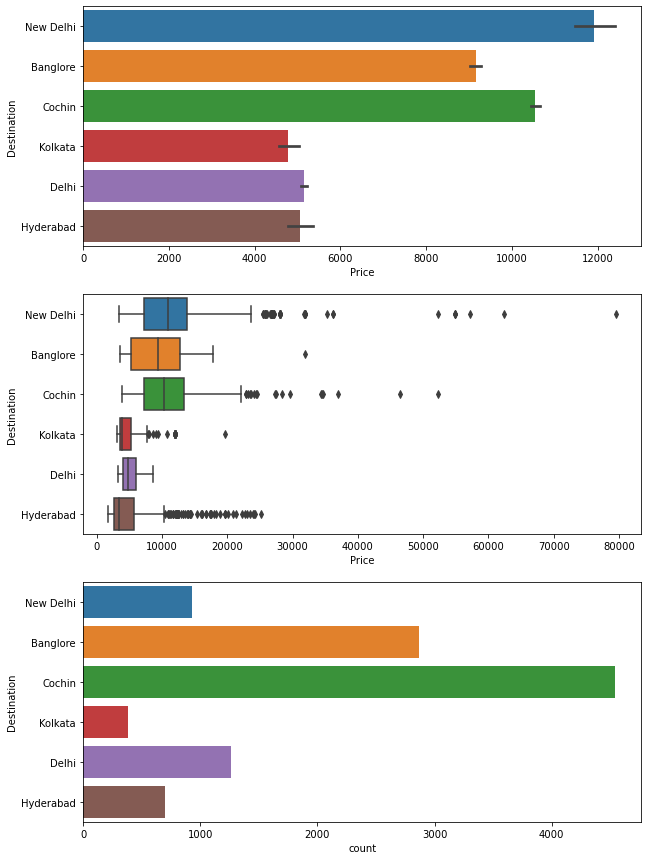

In [11]:
fig, ax = plt.subplots(3,1, figsize=(10,15))
sns.barplot(y='Destination', x='Price', data=df, ax=ax[0])
sns.boxplot(y='Destination', x='Price', data=df, ax=ax[1])
sns.countplot(y='Destination', data=df, ax=ax[2])
plt.show()

Flights whose destination are New Delhi have the highest price and that makes sense because its the capital of India

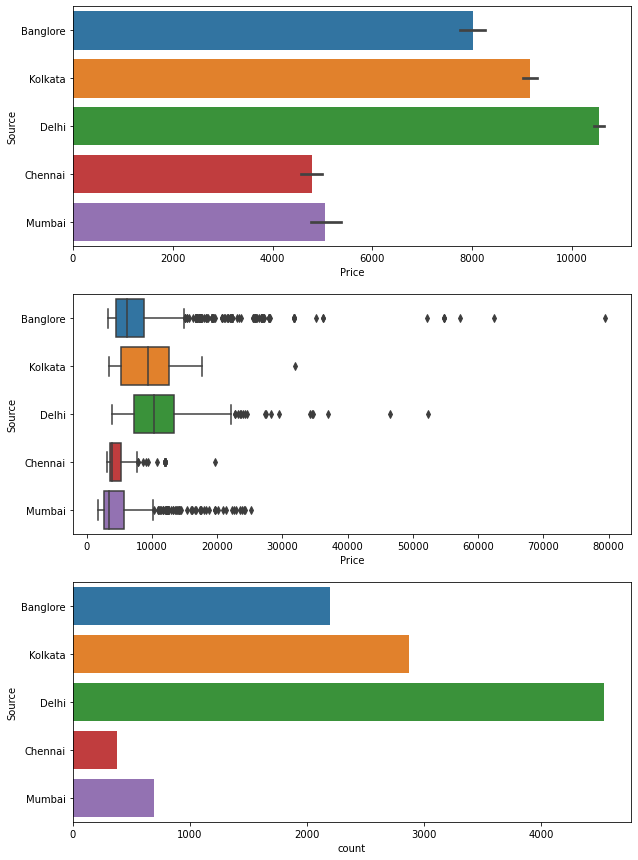

In [12]:
fig, ax = plt.subplots(3,1, figsize=(10,15))
sns.barplot(y='Source', x='Price', data=df, ax=ax[0])
sns.boxplot(y='Source', x='Price', data=df, ax=ax[1])
sns.countplot(y='Source', data=df, ax=ax[2])
plt.show()

Let's turn our other columns into numerical features. 
At first we turn the Dep_Time columns into two columns of hour and minute of departure
And we do the same to the Arrival_Time, and the Duration column

In [13]:
df['Dep_H'] = df.apply(lambda x: int(x['Dep_Time'].split(':')[0]), axis=1)
df['Dep_M'] = df.apply(lambda x: int(x['Dep_Time'].split(':')[1]), axis=1)

In [14]:
df['Arrival_Time_H'] = df.apply(lambda x: int(x['Arrival_Time'].split(':')[0]), axis=1)
df['Arrival_Time_M'] = df.apply(lambda x: int(x['Arrival_Time'].split(':')[1].split(' ')[0]), axis=1)

In [15]:
# there are some columns that don't have hour or minute so we have to add an if-else statement to not come to any errors
df['Duration_H'] = df['Duration'].apply(lambda x: int(x.split('h')[0]) if 'h' in x else 0)
df['Duration_M'] = df['Duration'].apply(lambda x: 0 if 'm' not in x else int(x.split('h')[1].split('m')[0]) if 'h' in x else 0)

In [16]:
# Let's drop these columns after extracting their useful information
df = df.drop(columns=['Dep_Time', 'Arrival_Time', 'Duration'], axis=1)

In [17]:
# Turn the Date column into 2 columns of the day and month. Since they are all in 2019 we don't make another column for year
df['date_M'] = df.apply(lambda x: int(x['Date_of_Journey'].split('/')[1]), axis=1)
df['date_D'] = df.apply(lambda x: int(x['Date_of_Journey'].split('/')[0]), axis=1)
df = df.drop('Date_of_Journey', axis=1)

In [18]:
df['Total_Stops'].value_counts()
# We can either one-hot encode this feature or label encode them from 0 to 4 
# I chose label encoding because here it makes sense since the distance between 1 stop and 3 stops is actually 2 

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [19]:
df = df.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4})

In [20]:
# At last we perform one-hot encoding on the remaining columns
data_train = pd.get_dummies(df, drop_first=True, columns=['Source', 'Airline', 'Destination'])

Now our data has turned into a format we can feed into models and train them!

In [21]:
# Train test split
X = data_train.drop('Price', axis=1)
y = data_train['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# To use lightGBM we should turn our train and test data into a lightgbm Dataset object
train_data = lightgbm.Dataset(X_train, y_train)
val_data = lightgbm.Dataset(X_test, y_test, reference=train_data)

In [23]:
# let's initialize some parameters as lightGBM needs them to perform 
# You're welcome to change these to obtain better results
params = {'objective': 'tweedie',
          'metric': ['Huber', 'rmse'],
          'learning_rate': 0.1,
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'feature_fraction': 0.9,
          'min_data_in_leaf': 20,
          'num_leaves': 41,
          'scale_pos_weight': 1.2,
          'lambda_l2': 1,
          'lambda_l1': 1
          }

In [24]:
# Training
gbm = lightgbm.train(params=params,
                     train_set=train_data,
                     valid_sets=[train_data, val_data],
                     valid_names=['train', 'valid'])

[1]	train's huber: 3023.83	train's rmse: 4345.69	valid's huber: 3012.08	valid's rmse: 4194.81
[2]	train's huber: 2782.77	train's rmse: 4075.38	valid's huber: 2764.97	valid's rmse: 3905.74
[3]	train's huber: 2574.68	train's rmse: 3841.08	valid's huber: 2552.66	valid's rmse: 3659.45
[4]	train's huber: 2393.18	train's rmse: 3639.28	valid's huber: 2368.52	valid's rmse: 3448
[5]	train's huber: 2235.36	train's rmse: 3458.57	valid's huber: 2208.39	valid's rmse: 3260.86
[6]	train's huber: 2102.31	train's rmse: 3295.33	valid's huber: 2071.98	valid's rmse: 3092.24
[7]	train's huber: 1993.14	train's rmse: 3173.56	valid's huber: 1963.58	valid's rmse: 2976.25
[8]	train's huber: 1893.38	train's rmse: 3050.08	valid's huber: 1861.69	valid's rmse: 2848.49
[9]	train's huber: 1803.85	train's rmse: 2940.45	valid's huber: 1772.34	valid's rmse: 2734.91
[10]	train's huber: 1728.66	train's rmse: 2840.91	valid's huber: 1696.89	valid's rmse: 2633.58
[11]	train's huber: 1665.82	train's rmse: 2757.95	valid's hube

Let's see how our model performs on the test set

In [25]:
print(r2_score(y_test, gbm.predict(X_test)), mean_squared_error(y_test, gbm.predict(X_test)))

0.8363273254370414 3339074.216800278


So we get around 83% R2 score

Now we perform the same preprocessing on Test_set.xlsx
and submit

In [26]:
df = pd.read_excel('../input/flight-fare-prediction-mh/Test_set.xlsx', engine='openpyxl')
df = df.dropna()
df = df.drop(columns=['Additional_Info', 'Route'], axis=1)
df['Dep_H'] = df.apply(lambda x: int(x['Dep_Time'].split(':')[0]), axis=1)
df['Dep_M'] = df.apply(lambda x: int(x['Dep_Time'].split(':')[1]), axis=1)
df['Arrival_Time_H'] = df.apply(lambda x: int(x['Arrival_Time'].split(':')[0]), axis=1)
df['Arrival_Time_M'] = df.apply(lambda x: int(x['Arrival_Time'].split(':')[1].split(' ')[0]), axis=1)
df['Duration_H'] = df['Duration'].apply(lambda x: int(x.split('h')[0]) if 'h' in x else 0)
df['Duration_M'] = df['Duration'].apply(lambda x: 0 if 'm' not in x else int(x.split('h')[1].split('m')[0]) if 'h' in x else 0)
df = df.drop(columns=['Dep_Time', 'Arrival_Time', 'Duration'], axis=1)
df['date_M'] = df.apply(lambda x: int(x['Date_of_Journey'].split('/')[1]), axis=1)
df['date_D'] = df.apply(lambda x: int(x['Date_of_Journey'].split('/')[0]), axis=1)
df = df.drop('Date_of_Journey', axis=1)
df = df.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4})
df = df.replace(['Trujet', 'Vistara Premium economy', 'Jet Airways Business', 'Multiple carriers Premium economy'], 'Other')
data_test = pd.get_dummies(df, drop_first=True, columns=['Source', 'Airline', 'Destination'])

In [27]:
X_test = data_test
y_test = gbm.predict(X_test)

In [28]:
my_submission = pd.DataFrame({'Price': y_test})
my_submission.to_csv('submission.csv', index=False)